In [1]:
!pip install -qU rasterio

In [2]:
import os
import sys

import numpy as np
import pandas as pd
import cv2
import glob
# import gdcm
import yaml
import torch
# import pydicom
import zipfile
import matplotlib.pyplot as plt

from PIL import Image
from pathlib import Path
from rasterio import features
from tqdm.notebook import tqdm
from joblib import Parallel, delayed
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from sklearn.model_selection import train_test_split

In [3]:
def decode_rle(rle_str, img_shape):
    """
    This function decodes a string of run-length encoded (RLE) pixel data into
    a binary mask.
    """
    mask = np.zeros(img_shape[0]*img_shape[1], dtype=np.uint8)
    pairs = rle_str.split(' ')
    for i in range(0, len(pairs), 2):
        start = int(pairs[i]) - 1  # RLE coordinates are 1-indexed
        length = int(pairs[i+1])
        end = start + length
        mask[start:end] = 1
    mask = mask.reshape(img_shape[0], img_shape[1])
    return mask


def create_label(image_paths, label_path, label_file_path):
    """
    Create a label file for YOLO by referring to an input image and label file.

    Parameters:
        image_path (list): Path to the input image.
        label_path (str): Path to the label file in CSV format.
        label_file_path (str): Path to the output label text file.

    Returns:
        None.
    """
    label_df = pd.read_csv(label_path)
    for img_path in tqdm(image_paths):
        img_name = img_path.split("/")[-1].split('.')[0]
        img = Image.open(img_path)
        img_shape = img.size[::-1]
        label_lines = []
        for _, row in label_df[label_df['ImageId'] == img_name].iterrows():
            mask = decode_rle(row['EncodedPixels'], img_shape)
            cords = list(features.shapes(mask, mask=(mask > 0)))[0][0]['coordinates'][0]
            label_line = '0 ' + ' '.join([f'{int(cord[0])/img_shape[0]} {int(cord[1])/img_shape[1]}' for cord in cords])
            label_lines.append(label_line)
        label_file_name = img_name.split(".")[0] + ".txt"
        with Path(label_file_path).joinpath(label_file_name).open('w') as f:
            f.write('\n'.join(label_lines))

In [4]:
image_paths = glob.glob('./dataset/images/*.png')
label_path = './data/stage1_train_labels.csv'
label_file_path = './dataset/labels'

In [ ]:
create_label(image_paths, label_path, label_file_path)

In [6]:
label_df = pd.read_csv(label_path)

img_path = image_paths[0]
img_name = img_path.split("/")[-1].split('.')[0]

In [7]:
hmm_index = label_df.loc[label_df['ImageId']=='6b0ac2ab04c09dced54058ec504a4947f8ecd5727dfca7e0b3f69de71d0d31c7'].index[2]

hmm_index

13069

In [25]:
label_df.iloc[hmm_index][]

ImageId          6b0ac2ab04c09dced54058ec504a4947f8ecd5727dfca7...
EncodedPixels    73257 13 73512 24 73768 27 74024 29 74280 31 7...
Name: 13069, dtype: object

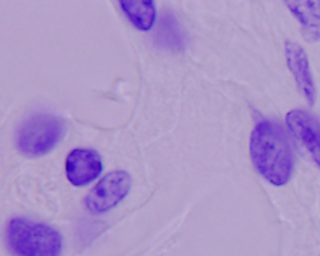

In [8]:
hmm_img_path = './dataset/images/6b0ac2ab04c09dced54058ec504a4947f8ecd5727dfca7e0b3f69de71d0d31c7.png'
hmm_img = Image.open(hmm_img_path)
hmm_img

In [9]:
hmm_img_shape = hmm_img.size[::-1]

In [10]:
hmm_img_shape

(256, 320)

In [11]:
hmm_rle_str = label_df.iloc[hmm_index]['EncodedPixels']

In [12]:
hmm_rle_str

'73257 13 73512 24 73768 27 74024 29 74280 31 74536 32 74793 33 75049 34 75306 35 75562 37 75818 39 76075 40 76332 41 76589 44 76846 47 77103 48 77361 47 77618 47 77876 47 78134 46 78391 46 78650 44 78907 44 79167 42 79425 41 79684 39 79944 35 80205 30 80468 22 80729 14'

In [13]:
hmm_mask = decode_rle(hmm_rle_str, hmm_img_shape)

In [14]:
hmm_mask

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [15]:
hmm_mask.shape

(256, 320)

In [40]:
list(features.shapes(hmm_mask, mask=(hmm_mask > 0)))[0][0]['coordinates'][0]

[(296.0, 228.0),
 (296.0, 229.0),
 (309.0, 229.0),
 (309.0, 228.0),
 (296.0, 228.0)]

In [ ]:
if use_segments:
    if len(ann['segmentation']) == 0:
        segments.append([])
        continue
    if isinstance(ann['segmentation'], dict):
        ann['segmentation'] = rle2polygon(ann['segmentation'])
    if len(ann['segmentation']) > 1:
        s = merge_multi_segment(ann['segmentation'])
        s = (np.concatenate(s, axis=0) / np.array([w, h])).reshape(-1).tolist()

def rle2polygon(segmentation):
    m = mask.decode(segmentation) 
    m[m > 0] = 255
    contours, _ = cv2.findContours(m, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_TC89_KCOS)
    polygons = []
    for contour in contours:
        epsilon = 0.001 * cv2.arcLength(contour, True)
        contour_approx = cv2.approxPolyDP(contour, epsilon, True)
        polygon = contour_approx.flatten().tolist()
        polygons.append(polygon)
    return polygons

In [16]:
from skimage import measure

In [17]:
contours = measure.find_contours(hmm_mask)

In [ ]:
contours[4]

In [26]:
# Convert the contours to polygons
polygons = []
for contour in contours:
    polygon = []
    for point in contour:
        polygon.append([point[1], point[0]])  # Note the switch in coordinates (y, x) -> (x, y)
    polygons.append(polygon)

# Print the polygon information
for polygon in polygons:
    print(polygon)

[[308.0, 228.5], [307.0, 228.5], [306.0, 228.5], [305.0, 228.5], [304.0, 228.5], [303.0, 228.5], [302.0, 228.5], [301.0, 228.5], [300.0, 228.5], [299.0, 228.5], [298.0, 228.5], [297.0, 228.5], [296.0, 228.5], [295.5, 228.0], [296.0, 227.5], [297.0, 227.5], [298.0, 227.5], [299.0, 227.5], [300.0, 227.5], [301.0, 227.5], [302.0, 227.5], [303.0, 227.5], [304.0, 227.5], [305.0, 227.5], [306.0, 227.5], [307.0, 227.5], [308.0, 227.5], [308.5, 228.0], [308.0, 228.5]]
[[254.0, 229.5], [253.0, 229.5], [252.0, 229.5], [251.0, 229.5], [250.0, 229.5], [249.0, 229.5], [248.0, 229.5], [247.0, 229.5], [246.0, 229.5], [245.0, 229.5], [244.0, 229.5], [243.0, 229.5], [242.0, 229.5], [241.0, 229.5], [240.0, 229.5], [239.0, 229.5], [238.0, 229.5], [237.0, 229.5], [236.0, 229.5], [235.0, 229.5], [234.0, 229.5], [233.0, 229.5], [232.0, 229.5], [231.0, 229.5], [230.5, 229.0], [231.0, 228.5], [232.0, 228.5], [233.0, 228.5], [234.0, 228.5], [235.0, 228.5], [236.0, 228.5], [237.0, 228.5], [238.0, 228.5], [239.0